# Load data

In [1101]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'inheritance_state', 'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'singledel_maternal', 'singledel_paternal'])


In [1089]:
ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, _, disease_status = pieces[0:6]
            child_id_to_affected[child_id] = disease_status

In [1382]:
from collections import defaultdict

# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()
family_to_indices = dict()

for i in ['22']:#[str(i) for i in range(1, 23)] + ['PAR1', 'PAR2']:
    fams = set()
    for j in range(3, 7):
        #print('chrom %d, family_size %d' % (i, j))
        # load families
        
        with open('phased/chr.%s.familysize.%d.families.txt' % (i, j), 'r')  as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                family_to_individuals[family_key] = pieces[1:(1+j)]
                family_to_indices[family_key] = [int(x) for x in pieces[(1+j):]]
                fams.add(family_key)
                
        # load deletions
        with open('phased/chr.%s.familysize.%d.phased.txt' % (i, j), 'r')  as f:
            next(f) # skip header
            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
                start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+(j*2)):(6+(j*2))]]
                length = end_pos - start_pos + 1
                individuals = family_to_individuals[family_key]
                
                if sum(inheritance_state[:4]) > 0:
                    # there was an inherited deletion
                    doubledel, singledel, nodel = [], [], []
                    singledel_mat, singledel_pat = [], []
                    
                    # mom
                    #if sum(inheritance_state[:2]) == 2:
                    #    doubledel.append(individuals[0])
                    #elif sum(inheritance_state[:2]) == 1:
                    #    singledel.append(individuals[0])
                    #else:
                    #    nodel.append(individuals[0])
                        
                    # dad
                    #if sum(inheritance_state[2:4]) == 2:
                    #    doubledel.append(individuals[1])
                    #elif sum(inheritance_state[2:4]) == 1:
                    #    singledel.append(individuals[1])
                    #else:
                    #    nodel.append(individuals[1])
                        
                    # children
                    for k, child_id in enumerate(individuals[2:]):
                        mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                        
                        if inheritance_state[mat] == 1 and inheritance_state[2+pat] == 1:
                            doubledel.append(child_id)
                        elif inheritance_state[mat] == 1:
                            singledel.append(child_id)
                            singledel_mat.append(child_id)
                        elif inheritance_state[2+pat] == 1:
                            singledel.append(child_id)
                            singledel_pat.append(child_id)
                        else:
                            nodel.append(child_id)
                    
                    deletions.append(Deletion(family_key, i,
                                              start_pos, end_pos, start_index, end_index, length,
                                              inheritance_state, individuals,
                                              doubledel, singledel, nodel,
                                              singledel_mat, singledel_pat))
                
    print(i, 'Num fams', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', sum([sum(x.inheritance_state[:2]) for x in deletions]), 
      'paternal', sum([sum(x.inheritance_state[2:4]) for x in deletions]))



22 Num fams 867
deletions 614270 maternal 643099 paternal 770118


In [1383]:
print('Maternal inheritance rate', sum([len(x.singledel_maternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[:2]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[:2]) == 1]))
print('Paternal inheritance rate', sum([len(x.singledel_paternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[2:4]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[2:4]) == 1]))



Maternal inheritance rate 0.5059259893668184
Paternal inheritance rate 0.5398436751161109


# Check for outliers

outliers 0
[]


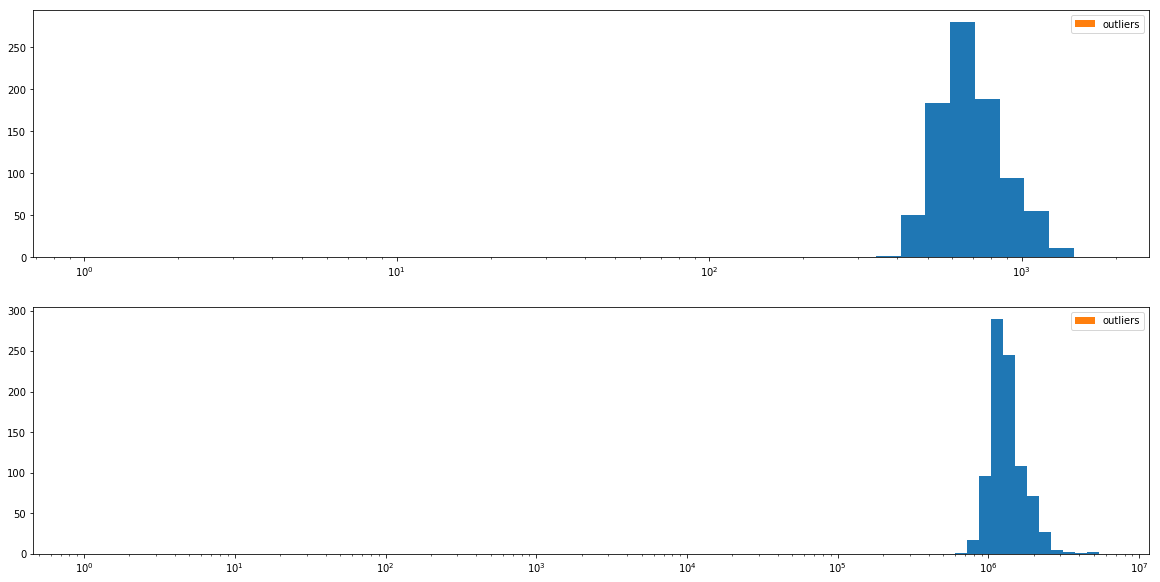

In [1384]:
from collections import defaultdict
from matplotlib import collections as mc

# deletions per family
plt.figure(figsize=(20, 10))

family_to_num_deletions = defaultdict(int)
family_to_nucleo_deleted = defaultdict(int)

for d in deletions:
    family_to_num_deletions[d.family] += 1
    family_to_nucleo_deleted[d.family] += d.length
    
outliers = [f for f in family_to_num_deletions.keys() if family_to_num_deletions[f] > 10000]
print('outliers', len(outliers))
print([(f, len(family_to_individuals[f])) for f in outliers])

base = 1.2

plt.subplot(2, 1, 1)
max_length = max(family_to_num_deletions.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_num_deletions.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_num_deletions.items() if f in outliers], bins=bins, label='outliers')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(2, 1, 2)
max_length = max(family_to_nucleo_deleted.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f in outliers], bins=bins, label='outliers')

plt.gca().set_xscale("log")
plt.legend()

#ax3 = plt.subplot(3, 1, 3)
#min_family = min(family_to_num_deletions.items(), key=lambda x:x[1])[0]
#max_family = max(family_to_num_deletions.items(), key=lambda x:x[1])[0]

#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==min_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='blue')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)
#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==max_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='red')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)

#plt.plot(sum([[d.start_pos, d.end_pos] for d in min_family_dels]), sum([[]]))
#plt.legend()
plt.show()

In [1385]:
deletions = [d for d in deletions if d.family not in outliers]
print(len(deletions))

614270


# Distribution of deletions

In [1386]:
from collections import Counter
# check double deletions
print(Counter([np.sum(d.inheritance_state[:4]) for d in deletions]))
print(Counter([tuple(d.inheritance_state[:4]) for d in deletions]))


Counter({2: 208857, 3: 185497, 1: 146884, 4: 73032})
Counter({(1, 1, 1, 1): 73032, (0, 1, 1, 1): 59897, (0, 0, 0, 1): 59444, (0, 0, 1, 1): 50459, (1, 0, 1, 1): 49235, (0, 0, 1, 0): 38393, (1, 1, 0, 1): 38344, (1, 1, 1, 0): 38021, (0, 1, 0, 1): 35906, (0, 1, 1, 0): 32834, (1, 0, 1, 0): 31676, (0, 1, 0, 0): 31466, (1, 0, 0, 1): 30254, (1, 1, 0, 0): 27728, (1, 0, 0, 0): 17581})


min length 1 max length 827035


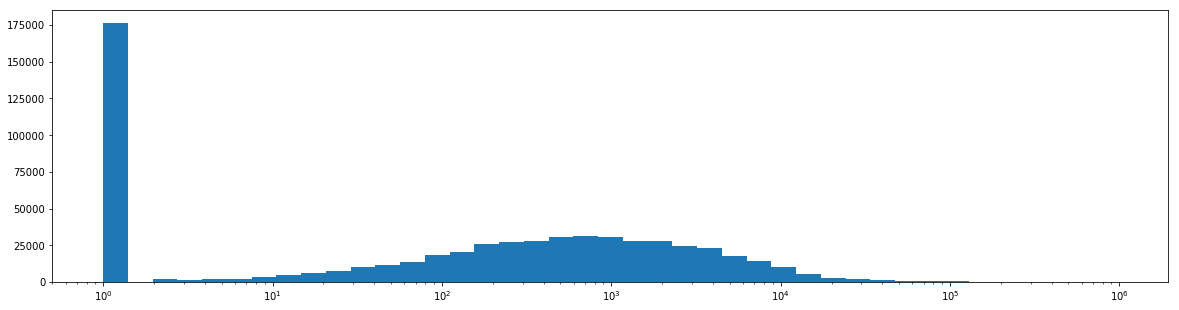

In [1387]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.length for d in deletions]) 
min_length = min([d.length for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.length for d in deletions], bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
plt.gca().set_xscale("log")
plt.show()

min length 0 max length 22039


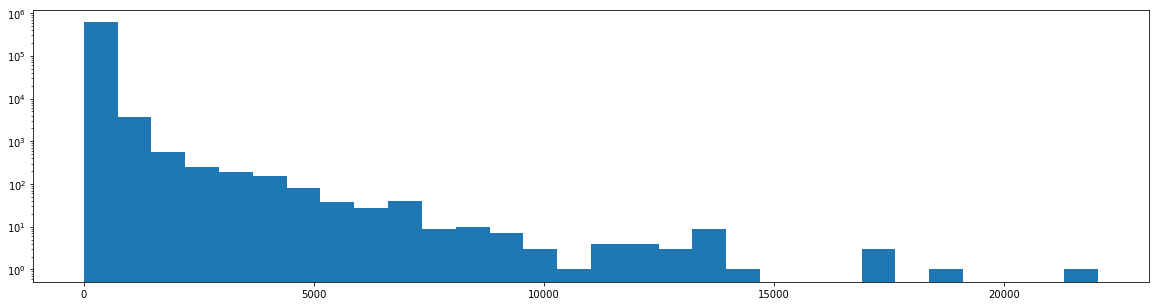

In [1388]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.end_index-d.start_index for d in deletions]) 
min_length = min([d.end_index-d.start_index for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.end_index-d.start_index for d in deletions], bins=30, log=True)#, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
#plt.gca().set_xscale("log")
plt.show()

In [1389]:
chrom = '22'
chrom_deletions = [d for d in deletions if d.chrom == i]
max_index = max([d.end_index for d in chrom_deletions])
snp_positions = np.zeros((max_index+1,))
        
conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
tdt_conting_t = np.zeros((max_index+1, 2, 2), dtype=int)
    
for d in chrom_deletions:
    conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
    conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
    conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel if child_id_to_affected[x] == '2'])
    conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel if child_id_to_affected[x] != '2'])
    conting_t[d.start_index:(d.end_index+1), 2, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
    conting_t[d.start_index:(d.end_index+1), 2, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
    
    if sum(d.inheritance_state[:2]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])
        
    if sum(d.inheritance_state[2:4]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])

        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
    snp_positions[d.start_index] = d.start_pos
    snp_positions[d.end_index] = d.end_pos

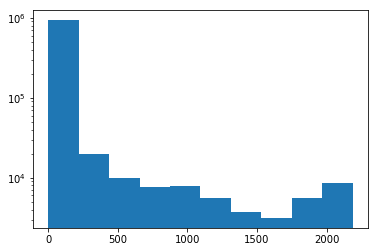

In [1390]:
areas_of_interest = np.sum(conting_t, axis=(1, 2))>0
areas_of_interest_tdt = np.sum(tdt_conting_t, axis=(1, 2))>50
plt.hist(np.sum(conting_t, axis=(1, 2)), log=True)
plt.show()


In [1391]:
print('Num peaks', np.sum(areas_of_interest[1:]-areas_of_interest[:-1]>0))
print('Num peaks TDT', np.sum(areas_of_interest_tdt[1:]-areas_of_interest_tdt[:-1]>0))

print('Num changes', np.where(areas_of_interest[1:] & areas_of_interest[:-1] & (np.sum(conting_t, axis=(1, 2))[1:] != np.sum(conting_t, axis=(1, 2))[:-1]))[0].shape)
print('Num changes TDT', np.where(areas_of_interest_tdt[1:] & areas_of_interest_tdt[:-1] & (np.sum(tdt_conting_t, axis=(1, 2))[1:] != np.sum(tdt_conting_t, axis=(1, 2))[:-1]))[0].shape)


Num peaks 342
Num peaks TDT 600
Num changes (25734,)
Num changes TDT (30593,)


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  """Entry point for launching an IPython kernel.
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  


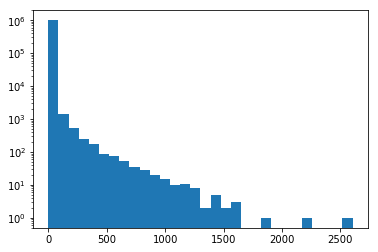

In [1395]:
tdt_num_people = np.sum(tdt_conting_t, axis=(1, 2))
plt.hist(np.abs(tdt_num_people[1:]-tdt_num_people[:-1]), log=True, bins=30)
plt.show()

52


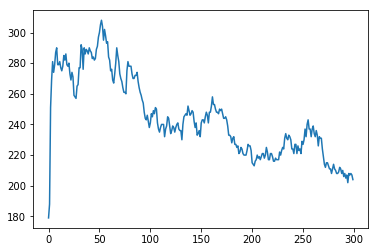

In [1466]:
xs = list(range(0, 300))
ys = [np.where((tdt_num_people[:-1] <= x) & (tdt_num_people[1:] > x))[0].shape[0] for x in xs]
plt.plot(xs, ys)
print(max(xs, key=lambda i: ys[i]))
plt.show()

(309,) (309,)


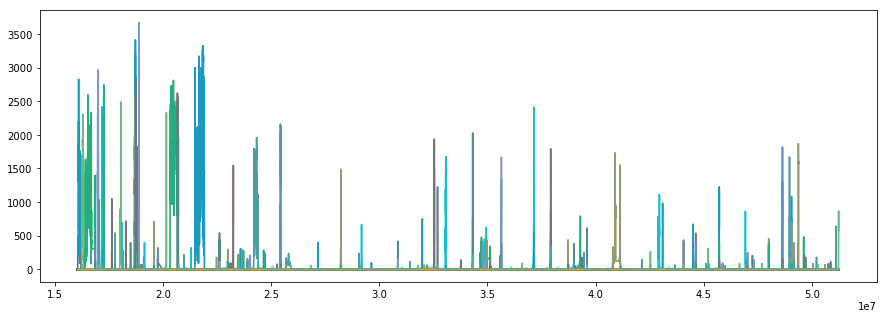

In [1467]:
peak_start_indices = np.where((tdt_num_people[:-1] <= 52) & (tdt_num_people[1:] > 52))[0]
peak_end_indices = np.where((tdt_num_people[:-1] > 52) & (tdt_num_people[1:] <= 52))[0]

if peak_start_indices[0] > peak_end_indices[0]:
    peak_start_indices = np.insert(peak_start_indices, 0, 0)
if peak_start_indices.shape[0] != peak_end_indices.shape[0]:
    peak_end_indices = np.insert(peak_end_indices, peak_end_indices.shape[0], max_index)
print(peak_start_indices.shape, peak_end_indices.shape)

plt.figure(figsize=(15, 5))
for ps, pe in zip(peak_start_indices, peak_end_indices):
    peak_positions = np.zeros((max_index+1,))
    peak_positions[(ps+1):(pe+1)] = tdt_num_people[(ps+1):(pe+1)]
    plt.plot(snp_positions[indices], peak_positions[indices])


plt.plot(snp_positions[indices], tdt_num_people[indices], alpha=0.5)

#plt.xticks(xticks, xticklabels, rotation='vertical')
plt.show()

In [1482]:
peak_family_to_deletions = defaultdict(list)

deletion_start_peak_start = np.searchsorted(peak_start_indices, [d.start_index for d in chrom_deletions])
deletion_end_peak_end = np.searchsorted(peak_end_indices, [d.end_index for d in chrom_deletions])

for d, ds, de in zip(chrom_deletions, deletion_start_peak_start, deletion_end_peak_end):
    for i in range(ds-1, de+1):
        ps, pe = peak_start_indices[i], peak_end_indices[i]
        if (d.start_index >= ps and d.start_index <= pe) or (d.end_index >= ps and d.end_index <= pe) or (d.start_index <= ps and d.end_index >= pe):
            if sum(d.inheritance_state[:2]) == 1:
                peak_family_to_deletions[(i, d.family, 'mat')].append(d)
            if sum(d.inheritance_state[2:4]) == 1:
                peak_family_to_deletions[(i, d.family, 'pat')].append(d)

In [1501]:
peak_pvalues = np.ones((max_index+1,))
peak_to_contingency = dict()
for (i, fam, matpat), dels in peak_family_to_deletions.items():
    trans, notrans = defaultdict(int), defaultdict(int)
    for d in dels:
        length = min(d.end_index, peak_end_indices[i]) - max(d.start_index, peak_start_indices[i])
        for c in d.doubledel:
            trans[c] += length
        for c in d.nodel:
            notrans[c] += length
       
        if matpat == 'mat':
            for c in d.singledel_maternal:
                trans[c] += length
            for c in d.singledel_paternal:
                notrans[c] += length
        else:
            for c in d.singledel_paternal:
                trans[c] += length
            for c in d.singledel_maternal:
                notrans[c] += length
            
    all_children = set(trans.keys() | notrans.keys())
    
    new_t = (len([x for x in all_children if trans[x] > 0 and child_id_to_affected[x] == '2']),
            len([x for x in all_children if trans[x] > 0 and child_id_to_affected[x] != '2']),
            len([x for x in all_children if trans[x] == 0 and child_id_to_affected[x] == '2']),
            len([x for x in all_children if trans[x] == 0 and child_id_to_affected[x] != '2']))
    if i in peak_to_contingency:
        t = peak_to_contingency[i]
        peak_to_contingency[i] = tuple(x+y for x, y in zip(t, new_t))
    else:
        peak_to_contingency[i] = new_t

for i, c in peak_to_contingency.items():   
    try:
        pvalue = chi2_contingency([[c[0], c[1]], [c[2], c[3]]])[1]
        peak_pvalues[peak_start_indices[i]:(peak_end_indices[i]+1)] = pvalue
    except:
        pass

In [1407]:
# cache pvalues
trans_to_pvalue = dict()
for i in np.where(areas_of_interest)[0]:
    t = tuple(np.reshape(conting_t[i, :, :], (6,)))
    if t not in trans_to_pvalue:
        try:
            trans_to_pvalue[t] = chi2_contingency(conting_t[i, :, :])[1]
        except:
            trans_to_pvalue[t] = 1
            
    t = tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))
    if t not in trans_to_pvalue:
        try:
            trans_to_pvalue[t] = chi2_contingency(conting_t[i, :, :])[1]
        except:
            trans_to_pvalue[t] = 1


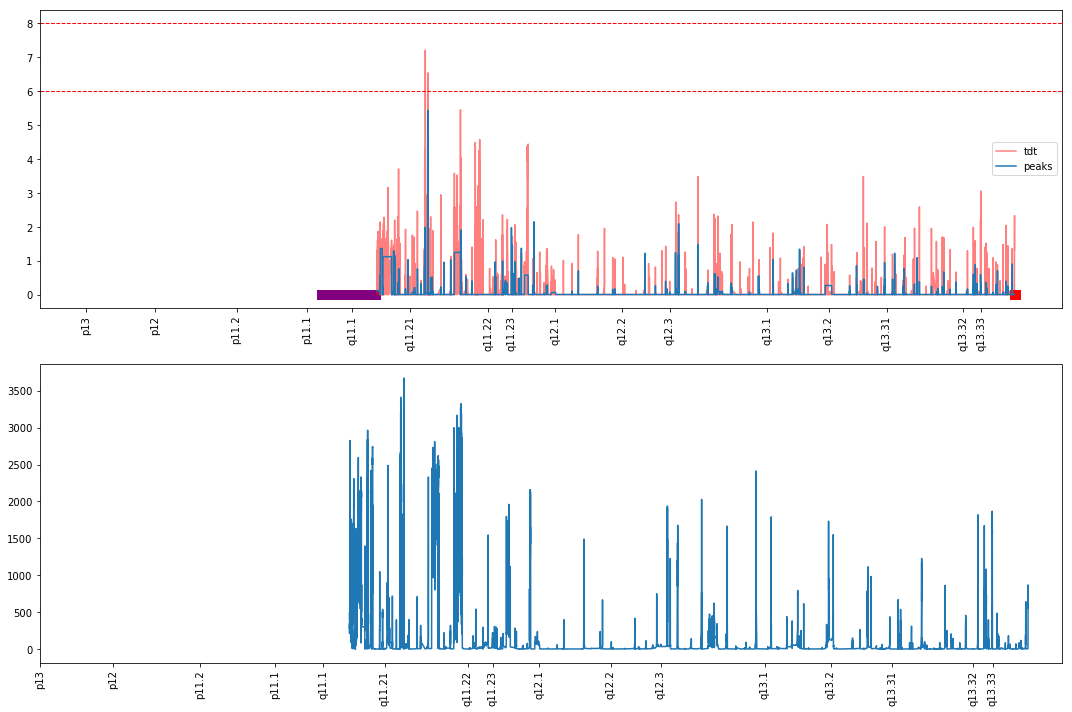

In [1502]:
import numpy as np
from scipy.stats import binom

# position of deletions
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

indices = np.where(snp_positions > 0)[0]
 
#p_values = np.ones((max_index+1,))
#p_values[areas_of_interest] = [trans_to_pvalue[tuple(np.reshape(conting_t[i, :, :], (6,)))] for i in np.where(areas_of_interest)[0]]
#plt.plot(snp_positions[indices], -np.log10(p_values[indices]), alpha=0.5, label='deletions')

# Pull centromere positions
with open('centromere_telomere_grch37_ucsc.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'centromere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='purple', linewidth=10)
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'telomere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='red', linewidth=10)
                
# Pull cytogenetic coordinates
with open('cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
                                             

p_values = np.ones((max_index+1,))
p_values[areas_of_interest] = [trans_to_pvalue[tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))] for i in np.where(areas_of_interest)[0]]
plt.plot(snp_positions[indices], -np.log10(p_values[indices]), alpha=0.5, label='tdt', color='red')
plt.plot(snp_positions[indices], -np.log10(peak_pvalues[indices]), label='peaks')

#ax[index].set_xticks(xticks + [i for i in range(int(snp_positions[0]), int(snp_positions[-1]), 2000000)])
#ax[index].set_xticklabels(xticklabels + [str(i/1000000) for i in range(int(snp_positions[0]), int(snp_positions[-1]), 2000000)], rotation='vertical')
   
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=8, linewidth=1, linestyle='--', color='r')
plt.axhline(y=6, linewidth=1, linestyle='--', color='r')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(snp_positions[indices], np.sum(tdt_conting_t, axis=(1, 2))[indices])
plt.xticks(xticks, xticklabels, rotation='vertical')


plt.tight_layout()
plt.show()

# Let's consider missing deletions
We won't be able to detect a deletion if it isn't inherited. So what fraction of the genome isn't inherited?

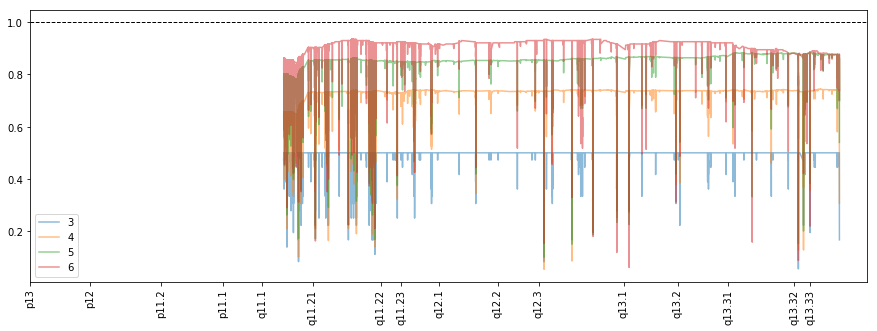

In [1376]:
plt.figure(figsize=(15, 5))

for j in range(3, 7):
    inherited = np.zeros((max_index+1,), dtype=int)
    famkeys = set()

    with open('phased/chr.%s.familysize.%d.phased.txt' % (chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+j*2)]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+j*2):(6+j*2)]]
                
            m1_inh, m2_inh, p1_inh, p2_inh = 0, 0, 0, 0
            for k, s in enumerate(inheritance_state[4:]):
                if k % 2 == 0:
                    m1_inh += (s==0)
                    m2_inh += (s==1)
                else:
                    p1_inh += (s==0)
                    p2_inh += (s==1)
                        
            if m1_inh:
                inherited[start_index:(end_index+1)] += 1
            if m2_inh:
                inherited[start_index:(end_index+1)] += 1
            if p1_inh:
                inherited[start_index:(end_index+1)] += 1
            if p2_inh:
                inherited[start_index:(end_index+1)] += 1
            
            famkeys.add(family_key)


        plt.plot(snp_positions[indices], inherited[indices]/(4*len(famkeys)), label=str(j), alpha=0.5)
        plt.xticks(xticks, xticklabels, rotation='vertical')

plt.axhline(y=1, linewidth=1, linestyle='--', color='black')

plt.legend()
plt.show()

# Investigate deletions in cytogenetic regions

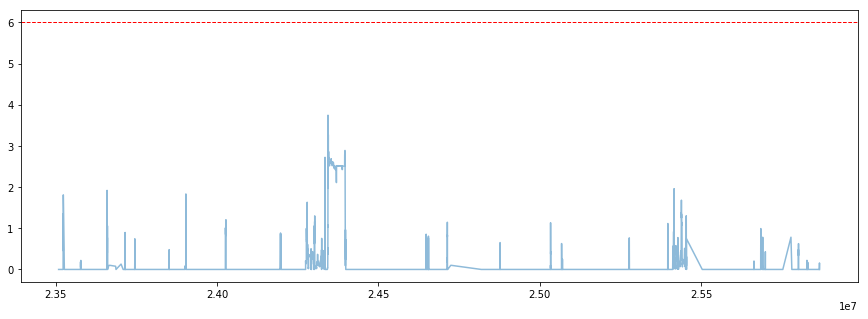

In [1333]:
#start, end = 23500000, 25900000
#start, end = 24340000, 24400000
region = 'q11.23'
region_index = xticklabels.index(region)
start, end = xticks[region_index], snp_positions[indices][-1] if region_index == len(xticks)-1 else xticks[region_index+1]
region_indices = [i for i in indices if snp_positions[i]>= start and snp_positions[i] <= end]

plt.figure(figsize=(15, 5))
p_values = np.ones((max_index+1,))
p_values[areas_of_interest] = [trans_to_pvalue[tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))] for i in np.where(areas_of_interest)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='tdt')

plt.axhline(y=6, linewidth=1, linestyle='--', color='r')
plt.show()

24340000 24400000


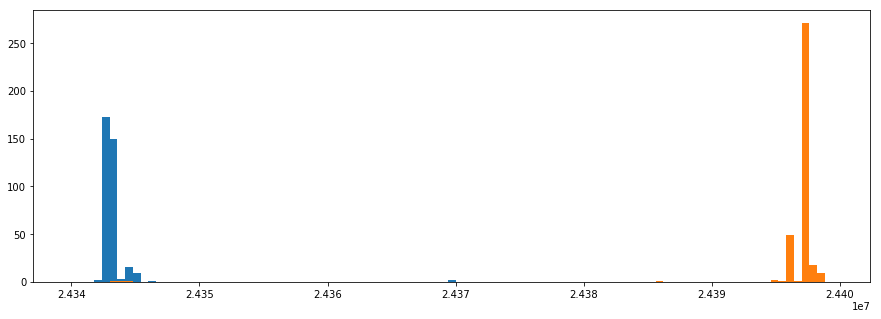

In [1286]:
#print('Peak', 1)
#peak_start, peak_end = peaks[2], peaks[3]
print(peak_start, peak_end)
peakdels = [d for d in deletions if d.chrom == '22' and d.start_pos >= start and d.end_pos <= end+1]

family_to_start, family_to_end = dict(), dict()
for d in peakdels:
    if d.family in family_to_start:
        family_to_start[d.family] = min(family_to_start[d.family], d.start_pos)
    else:
        family_to_start[d.family] = d.start_pos
        
    if d.family in family_to_end:
        family_to_end[d.family] = max(family_to_end[d.family], d.end_pos)
    else:
        family_to_end[d.family] = d.end_pos


plt.figure(figsize=(15, 5))
plt.hist(list(family_to_start.values()), bins=range(peak_start, peak_end, 600))
plt.hist(list(family_to_end.values()), bins=range(peak_start, peak_end, 600))
    
plt.show()